In [1]:
from sunpy.util import scraper
from sunpy.time import TimeRange, parse_time
import pandas as pd
import urllib
import matplotlib.pyplot as plt
from matplotlib import dates
import os
import numpy as np
import datetime
from scipy.signal import savgol_filter
import matplotlib as mpl
mpl.rcParams['xtick.direction']= 'in'
mpl.rcParams['ytick.direction']= 'in'

import seaborn as sns
sns.set_context("paper")

In [2]:
def get_vlf_data(tstart, tend, transmitter="DHO38", reciever="birr"):

    if reciever == "birr":
        filename = "Birr"
    elif reciever == "dunsink":
        filename = "Dunsink"
    else:
        print("Not a valid reciever name")
        return
    
    vlf_pattern = "https://vlf.ap.dias.ie/data/{reciever}/%Y/%m/%d/csv/{filename}_{transmitter}_%Y-%m-%d_000000.csv"
    vlf_scraper = scraper.Scraper(vlf_pattern, transmitter=transmitter, reciever=reciever, filename=filename)
    files = vlf_scraper.filelist(TimeRange(tstart, tend))
    return files

In [3]:
def get_urls(urls):
    if not os.path.exists(urls[0].split('/')[-1]):
        urllib.request.urlretrieve(urls[0], urls[0].split('/')[-1])

In [5]:
birr_file = get_vlf_data("2021-04-22", "2021-04-22", transmitter="HWU")
dunsink_file = get_vlf_data("2021-04-22", "2021-04-22", transmitter="HWU", reciever="dunsink")

In [6]:
get_urls(birr_file)
get_urls(dunsink_file)

In [7]:
def read_vlf_data(file):
    """
    Read VLF csv files and return a pandas Series
    """
    aa = pd.read_csv(file, comment="#", names=["date", "data"])
    sid = pd.Series(20*np.log10(aa["data"].values), index=pd.to_datetime(aa["date"]))
    return sid

In [8]:
birr_data = read_vlf_data(birr_file[0].split("/")[-1])
dunsink_data = read_vlf_data(dunsink_file[0].split("/")[-1])

/Users/laurahayes/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


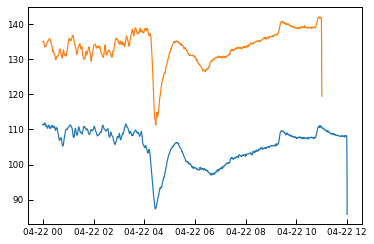

In [15]:
#plt.plot(birr_data.index, 20*np.log10(birr_data))
plt.plot(dunsink_data)
plt.plot(birr_data)

In [18]:
dunsink_data.index

DatetimeIndex(['2021-04-22 00:00:00', '2021-04-22 00:00:05',
               '2021-04-22 00:00:10', '2021-04-22 00:00:15',
               '2021-04-22 00:00:20', '2021-04-22 00:00:25',
               '2021-04-22 00:00:30', '2021-04-22 00:00:35',
               '2021-04-22 00:00:40', '2021-04-22 00:00:45',
               ...
               '2021-04-22 23:59:10', '2021-04-22 23:59:15',
               '2021-04-22 23:59:20', '2021-04-22 23:59:25',
               '2021-04-22 23:59:30', '2021-04-22 23:59:35',
               '2021-04-22 23:59:40', '2021-04-22 23:59:45',
               '2021-04-22 23:59:50', '2021-04-22 23:59:55'],
              dtype='datetime64[ns]', name='date', length=17280, freq=None)

In [19]:
tstart = "2021-04-22 08:00"
tend = "2021-04-22 11:50"

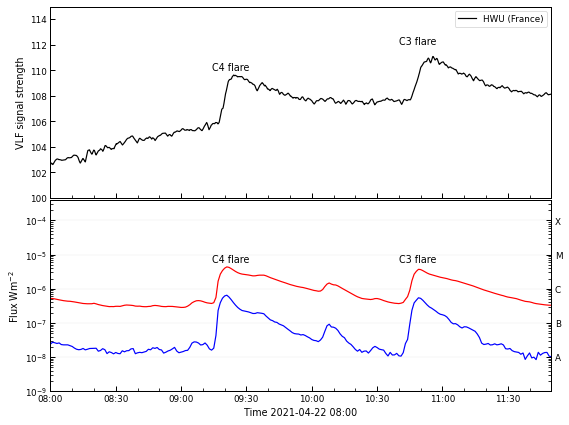

In [41]:
fig, ax = plt.subplots(2, sharex=True, figsize=(8, 6))

# plot the VLF data
ax[0].plot(dunsink_data.truncate(tstart, tend).index, 
           dunsink_data.truncate(tstart, tend), label="HWU (France)", color="k")
# ax[0].plot(birr_data.truncate(tstart, tend))
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[0].legend(loc="upper right")

# plot the GOES data
ax[1].plot(gl.truncate(tstart, tend), color='r')
ax[1].plot(gs.truncate(tstart, tend), color='b')
ax[1].set_yscale("log")

ax[1].set_xlim(parse_time(tstart).datetime, parse_time(tend).datetime)
ax[0].set_ylabel("VLF signal strength")
ax[1].set_ylabel("Flux Wm$^{-2}$")
ax[1].set_xlabel("Time {:s}".format(tstart))




ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[1].xaxis.set_minor_locator(dates.MinuteLocator(interval=10))
ax[1].set_ylim(1e-9, 4e-4)
ax[1].yaxis.grid(lw=0.1)
ax[0].set_ylim(100, 115)
ax1_rhs = ax[1].twinx()
ax[1].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax1_rhs.set_yscale("log")
ax1_rhs.set_ylim(1e-9, 4e-4)
ax1_rhs.set_yticks((1e-8, 1e-7, 1e-6, 1e-5, 1e-4))
ax1_rhs.set_yticklabels(('A', 'B', 'C', 'M', 'X'))
# for a in ax:
#     #a.axvline(parse_time("2021-04-17 17:17").datetime, ls="dashed", color="grey")
#     a.axvspan(parse_time("2021-04-17 16:21").datetime, parse_time("2021-04-17 17:40").datetime, 
#               color="grey", alpha=0.3)

ax[1].text(parse_time("2021-04-22 09:14").datetime, 6e-6, "C4 flare")
ax[0].text(parse_time("2021-04-22 09:14").datetime, 110, "C4 flare")

ax[1].text(parse_time("2021-04-22 10:40").datetime, 6e-6, "C3 flare")
ax[0].text(parse_time("2021-04-22 10:40").datetime, 112, "C3 flare")


plt.tight_layout()
plt.subplots_adjust(hspace=0.01)
plt.savefig("apr22_1345.png", facecolor="w", dpi=200)


In [28]:
np.max(gl)

1.105562932934844e-05

In [10]:
def get_recent_goes():
    """
    Pull the most recent GOES X-ray data from the NOAA page
    
    Returns the GOES short and long channels as pandas series
    """
    data = pd.read_json("https://services.swpc.noaa.gov/json/goes/primary/xrays-7-day.json")
    data_short = data[data["energy"]=="0.05-0.4nm"]
    data_long = data[data["energy"]=="0.1-0.8nm"]
    time_array = [parse_time(x).datetime for x in data_short['time_tag'].values]

    gl = pd.Series(data_long["flux"].values, index=time_array)
    gs = pd.Series(data_short["flux"].values, index=time_array)
    return gl, gs

gl, gs = get_recent_goes()

In [ ]:
fig, ax = plt.subplots(2, sharex=True, figsize=(9, 6))

# plot the VLF data
ax[0].plot(sid.truncate(tstart, tend), label="DHO38", color="k")
ax[0].xaxis.set_major_formatter(dates.DateFormatter("%H:%M"))
ax[0].legend()

# plot the GOES data
ax[1].plot(gl.truncate(tstart, tend), color='r')
ax[1].plot(gs.truncate(tstart, tend), color='b')
ax[1].set_yscale("log")

In [46]:
import cartopy.crs as ccrs
from cartopy.feature.nightshade import Nightshade
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

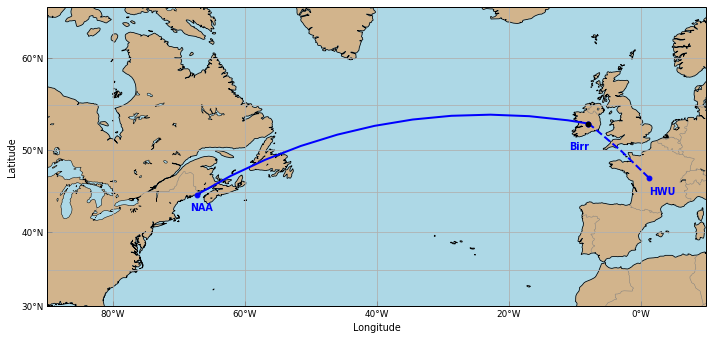

In [71]:
point_colors_naa = "blue"
point_colors_hwu = "red"
img_colors = False

# there is an issue with the resolution for
# plotting great circle, this is a hack to overwrite
# the threshold.
projection = ccrs.Miller()
class hacked_miller(ccrs.Miller):
    @property
    def threshold(self):
        return 0.05

projection = hacked_miller()

fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=projection)

# setting up tick labels etc
ax.set_xticks(np.arange(0, 360,20) , crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-90, 90, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.gridlines()

# add in features of interest on map
ax.set_extent((-90, 10, 30, 65), crs=ccrs.PlateCarree())
ax.coastlines(resolution="50m")
ax.add_feature(cfeature.BORDERS, lw=0.5, color="grey")
ax.add_feature(cfeature.LAND, facecolor="tan")
ax.add_feature(cfeature.OCEAN, facecolor="lightblue")

# hack to allow LAKE feature to have both edgecolor and facecolor
hacked_lake = cfeature.NaturalEarthFeature(cfeature.LAKES.category, cfeature.LAKES.name, cfeature.LAKES.scale, 
                                edgecolor="k", lw=0.5)
ax.add_feature(hacked_lake, facecolor="lightblue")

# if True then overplot colors of land/sea from image
if img_colors:
    ax.stock_img()

# plot the locations of transmitter/reciever
naa_lat, naa_lon = 44.644506, -67.284565
hwu_lat, hwu_lon = 46.714119, 1.244309

birr_lon, birr_lat = -7.9, 53

ax.text(naa_lon-1, naa_lat-2, "NAA", color=point_colors, weight="bold",
        transform=ccrs.Geodetic())
ax.text(birr_lon-3, birr_lat-3, "Birr", color=point_colors_naa, weight="bold", 
        transform=ccrs.Geodetic())

ax.text(hwu_lon, hwu_lat-2, "HWU", color=point_colors_naa, weight="bold",
        transform=ccrs.Geodetic() )

ax.plot([naa_lon, birr_lon], [naa_lat, birr_lat],
         color=point_colors_naa, linewidth=2, marker='o',
         transform=ccrs.Geodetic())

ax.plot([hwu_lon, birr_lon], [hwu_lat, birr_lat],
         color=point_colors_naa, linewidth=2, marker='o', ls="dashed",
         transform=ccrs.Geodetic())

ax.plot([birr_lon], [birr_lat],transform=ccrs.Geodetic(),
         color="k", linewidth=2, marker='o')

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()